## Introduction

The model is as follows:
$$\mu \sim \text{Uniform}(-2,2)$$
$$x_i \sim N(\mu, 1) \quad \text{for}\ i\ \text{in}\ \{1,2\}$$

We will try to infer the conditional distribution $p(x|\mu)$ using a conditional normalizing flow.


In [1]:
from jax import random
import jax.numpy as jnp
from jaxflows.bijections.coupling import CouplingStack
from jaxflows.bijections.rational_quadratic_spline import RationalQuadraticSpline
from jaxflows.flow import Flow
from jaxflows.train_utils import train_flow
import matplotlib.pyplot as plt

In [2]:
key, x_key, cond_key = random.split(random.PRNGKey(0), 3)
cond = random.uniform(cond_key, (10000, 1), minval=-1, maxval=1)
x = random.normal(x_key, (10000, 2)) + cond

In [3]:
key, subkey = random.split(key)
bijection = CouplingStack(
    key=subkey,
    bijection=RationalQuadraticSpline(K=8, B=5),
    D=x.shape[1],
    num_layers=5,
    condition_dim=cond.shape[1])

flow = Flow(bijection, target_dim = x.shape[1])


In [4]:
key, subkey = random.split(key)
flow, losses = train_flow(flow, subkey, x, cond)

 58%|█████▊    | 29/50 [00:50<00:36,  1.73s/it, train=2.82, val=2.83]

Max patience reached.


## Sampling
We can now sample from the flow, for example conditioning on $\mu = 1$, which should be approximately a two dimensional $N(1, 1)$.


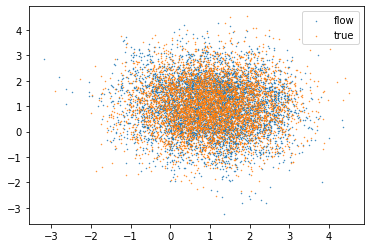

In [6]:
n = 5000
mean_of_one = jnp.ones((n, 1))
key, flow_key, true_key = random.split(key, 3)
sample = flow.sample(flow_key, n, condition=mean_of_one)
true = random.normal(true_key, sample.shape) + 1
plt.scatter(x = sample[:, 0], y = sample[:, 1], s=0.2, label="flow")
plt.scatter(x = true[:, 0], y = true[:, 1], s=0.2, label="true")
plt.legend()